# `PartitionShap`: EuroSAT (13-band) channel-wise demo

**Purpose:** This notebook compares the default implementation of `PartitionShap` to [CBI's fork](https://github.com/conrad-blucher-institute/shap) that implement's channel-wise explanations. 
That is, the default paritions images by splitting the rows and columns. Only at the pixel-level does it split across the channels/bands. For 3D inputs, it may be of interest to explain the contribution of bands on superpixel regions. 
The fork introduces the option to split first by channels, then by superpixels. 
This notebook also demonstrates that the choice of `masker` (how to represent features that are "not present") has a significant affect on the explanation. 

**Data:**
[EuroSAT multispectral (13 bands)](https://arxiv.org/abs/1709.00029)

**Notebooks in series**
- `PartitionShap`: ImageNet (RGB) channel-wise demo
- `PartitionShap`: EuroSAT (RGB) channel-wise demo
- `PartitionShap`: EuroSAT (13-band) channel-wise demo

# Setup environment

In [19]:
# Options
TRAIN = False # Load trained model instead
useCBIweights = True # Download Conrad Blutcher Institute's pretrained model
path_model = "eurosat_landuse_13bands.pt"

if useCBIweights:
  !gdown --id 1gYtOpYdMCCMxCkEhRzK1dDyE6tOMIOKa

Downloading...
From: https://drive.google.com/uc?id=1gYtOpYdMCCMxCkEhRzK1dDyE6tOMIOKa
To: /content/eurosat_landuse_13bands.pt
94.6MB [00:00, 127MB/s] 


In [2]:
# Install CBI's SHAP fork
!pip install git+https://github.com/conrad-blucher-institute/shap.git
# Install torchsat
!pip install develop git+https://github.com/sshuair/torchsat.git

  Cloning https://github.com/conrad-blucher-institute/shap.git to /tmp/pip-req-build-x7b19fzb
  Running command git clone -q https://github.com/conrad-blucher-institute/shap.git /tmp/pip-req-build-x7b19fzb
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=3069034 sha256=6212b20e23ee2bc6ba01250808ac859c9e80a4ba8ce639e290a6c797c1c82d3f
  Stored in directory: /tmp/pip-ephem-wheel-cache-6vo2z96b/wheels/3c/9a/93/11be35e411617629bbee7fb4f537a81c1aac0448cb017b72b0
Successfully built shap
  Cloning https://github.com/sshuair/torchsat.git to /tmp/pip-req-build-uelhszu8
  Running command git clone -q https://github.com/sshuair/torchsat.git /tmp/pip-req-build-uelhszu8
     |████████████████████████████████| 19.3 MB 1.2 MB/s 
     |████████████████████████████████| 994 kB 64.6 MB/s 
     |████████████████████████████████| 15.4 MB 38 kB/s 
     |████████████████████████████████| 6.6 MB 14.6 MB/s 
  Created wheel for torchsat: filename=torchsat-0.1.0.dev0-py3-none-any.w

In [3]:
# Torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
# Torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder
import torchvision.models as models
# Torchsat
import torchsat.transforms.functional as F
import torchsat.transforms.transforms_cls as T_cls
from torchsat.transforms import transforms_cls
import torchsat.datasets as datasets
from torchsat.datasets.folder import DatasetFolder
from torchsat.datasets.utils import tifffile_loader
import torchsat.models
from torchsat.models.classification.resnet import resnet18, resnet34, resnet50, resnet101, resnet152, resnext50_32x4d, resnext101_32x8d, wide_resnet50_2, wide_resnet101_2
# Sci
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
from PIL import Image
# General
import matplotlib.pyplot as plt
import copy
from collections import namedtuple
import os
import random
import shutil
import time
from pathlib import Path
import math
import tifffile
import shap
import pickle

# Load data
EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification

    Helber, Patrick, et al. "Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification." IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing 12.7 (2019): 2217-2226.

This uses a reduced dataset: only RGB of the original 13 bands

- Images: 27000
- Size: 64x64 (13 bands)
- Classes:
  - AnnualCrop (3000)
  - Forest (3000)
  - HerbaceousVegetation (3000)
  - Highway (2500)
  - Industrial (2500)
  - Pasture (2000)
  - PermanentCrop (2500)
  - Residential (3000)
  - River (2500)
  - SeaLake (3000) 
- Bands:
  - B01: Aerosols
  - B02: Blue
  - B03: Green
  - B04: Red
  - B05: Red edge 1
  - B06: Red edge 2
  - B07: Red edge 3
  - B08: NIR
  - B08A: Red edge 4
  - B09: Water vapor
  - B10: Cirrus
  - B11: SWIR 1
  - B12: SWIR 2

In [4]:
# Download data
# get the train data
!wget http://madm.dfki.de/files/sentinel/EuroSATallBands.zip
!unzip -q EuroSATallBands.zip
!mkdir -p EuroSATallBands EuroSATallBands/train EuroSATallBands/val
!ls ds/images/remote_sensing/otherDatasets/sentinel_2/tif/
!rsync -rP --remove-source-files --include='*2.tif' \
  --include="*/" --exclude='*' ./ds/images/remote_sensing/otherDatasets/sentinel_2/tif/* ./EuroSATallBands/val/
!mv ./ds/images/remote_sensing/otherDatasets/sentinel_2/tif/* ./EuroSATallBands/train


Streaming output truncated to the last 5000 lines.
        107,244 100%  943.52kB/s    0:00:00 (xfr#205, ir-chk=1195/1410)
AnnualCrop/AnnualCrop_2832.tif
        107,244 100%  943.52kB/s    0:00:00 (xfr#206, ir-chk=1194/1410)
AnnualCrop/AnnualCrop_2842.tif
        107,244 100%  943.52kB/s    0:00:00 (xfr#207, ir-chk=1193/1410)
AnnualCrop/AnnualCrop_2852.tif
        107,244 100%  935.09kB/s    0:00:00 (xfr#208, ir-chk=1192/1410)
AnnualCrop/AnnualCrop_2862.tif
        107,244 100%  935.09kB/s    0:00:00 (xfr#209, ir-chk=1191/1410)
AnnualCrop/AnnualCrop_2872.tif
        107,244 100%  926.82kB/s    0:00:00 (xfr#210, ir-chk=1190/1410)
AnnualCrop/AnnualCrop_2882.tif
        107,244 100%  926.82kB/s    0:00:00 (xfr#211, ir-chk=1189/1410)
AnnualCrop/AnnualCrop_2892.tif
        107,244 100%  918.69kB/s    0:00:00 (xfr#212, ir-chk=1188/1410)
AnnualCrop/AnnualCrop_2902.tif
        107,244 100%  918.69kB/s    0:00:00 (xfr#213, ir-chk=1187/1410)
AnnualCrop/AnnualCrop_2912.tif
        107,244 100%  

In [5]:
# Define transformers
train_transform = T_cls.Compose([
    T_cls.RandomHorizontalFlip(),
    T_cls.RandomVerticalFlip(),
    T_cls.ToTensor(),
])
val_transform = T_cls.Compose([
    T_cls.ToTensor(),
])

imgDir = "./EuroSATallBands/"

# Load data from folders
trainData = datasets.folder.DatasetFolder(Path(imgDir, "train"), datasets.utils.tifffile_loader, ".tif", transform=train_transform)
valData   = datasets.folder.DatasetFolder(Path(imgDir, "val"),   datasets.utils.tifffile_loader, ".tif")

# Data information
classes = trainData.classes
n_classes = len(classes)
n_train = len(trainData)
n_val = len(valData)

64 rows, 64 columns, 13 channels.


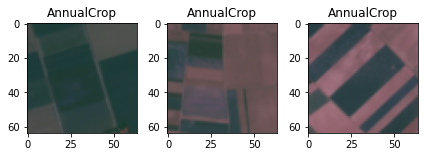

In [6]:
def imgShow(x, ax=None):
  img = Image.fromarray(np.uint8(x[:,:,1:4][:,:,(2, 0, 1)] >> 4))
  if ax == None:
    plt.imshow(img)
  ax.imshow(img)

def normShow(x, ax=None):
  # img = transforms.ToPILImage()(np.uint8(x[:,:,1:4][:,:,(2, 0, 1)] >> 4)).convert("RGB")
  img = transforms.ToPILImage()(val_transform(x[:,:,1:4][:,:,(2, 0, 1)] >> 4)).convert("RGB")
  
  if ax == None:
    plt.imshow(img)
  ax.imshow(img)

# Show sample images
fig, axs = plt.subplots(1, 3);
# Train sample
x,y = valData[0]
imgShow(x, ax=axs[0]);
axs[0].set_title(classes[y]);
# Validate sample
x,y = valData[1]
imgShow(x, ax=axs[1]);
axs[1].set_title(classes[y]);
# Test sample
x,y = valData[2]
imgShow(x, ax=axs[2]);
axs[2].set_title(classes[y]);
plt.tight_layout()
print("{} rows, {} columns, {} channels.".format(x.shape[0], x.shape[1], x.shape[2]))

# Train model

In [7]:
# Params
printFreq = 100
# Hardware
device = torch.device('cuda')
# Batch size
batchSize = 64
# Initial learning rate
learningRate = 0.1
# epochs
n_epochs = 100

In [8]:
train_loader = DataLoader(trainData, batch_size=batchSize, shuffle=True)
val_loader   = DataLoader(valData,   batch_size=batchSize, shuffle=False)

In [9]:
# Load model
torch.backends.cudnn.benchmark = True
model = resnet50(in_channels=13, num_classes=n_classes)
model.to(device)

# Define learning components
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learningRate)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [10]:
def train_one_epoch(model, criterion, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    for idx, (image, target) in enumerate(data_loader):
        image, target = image.to(device, dtype=torch.float), target.to(device)
        output = model(image)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if idx % print_freq == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, idx * len(image), len(data_loader.dataset), 100. * idx / len(data_loader), loss.item()))

In [23]:
def evaluate(model, criterion, data_loader, device):
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for idx, (image, target) in enumerate(data_loader):
            image = image.to(device, dtype=torch.float, non_blocking=True)
            target = target.to(device, non_blocking=True)
            output = model(image)
            loss += criterion(output, target).item()

            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

        loss /= len(data_loader.dataset)/data_loader.batch_size

        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            loss, correct, len(data_loader.dataset),
            100. * correct / len(data_loader.dataset)))

In [12]:
if TRAIN:
  for epoch in range(n_epochs):
    train_one_epoch(model, criterion, optimizer, train_loader, device, epoch, printFreq)
    lr_scheduler.step()
    # evaluate(epoch, model, criterion, val_loader, device)

In [20]:
# Save model
if TRAIN:
  torch.save(model, path_model)

# Load model
model = torch.load(path_model)
model.eval();

# Evaluate model

In [21]:
# Make validation data loader again, this time with the transform
# (earlier, did not use transform for easier plotting)
valData   = datasets.folder.DatasetFolder(Path(imgDir, "val"),   datasets.utils.tifffile_loader, ".tif", transform=train_transform)
val_loader   = DataLoader(valData,   batch_size=batchSize, shuffle=False)

In [24]:
evaluate(model, criterion, val_loader, device)

Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)



Test set: Average loss: 0.2155, Accuracy: 2541/2700 (94%)



In [25]:
class_to_idx = {
        'AnnualCrop': 0,
        'Forest': 1,
        'HerbaceousVegetation': 2,
        'Highway': 3,
        'Industrial': 4,
        'Pasture': 5,
        'PermanentCrop': 6,
        'Residential': 7,
        'River': 8,
        'SeaLake': 9,
    }
idx_to_class = {v: k for k, v in class_to_idx.items()}

In [26]:
def getPredictions(model, data_loader, device, print_freq):
    model.eval()
    trueLabels = []
    predLabels = []
    # model.to(device, non_blocking=True, type=torch.double)
    model = model.to("cpu", dtype=torch.double)
    with torch.no_grad():
        for idx, (image, target) in enumerate(data_loader):
            # image = image.to(device, non_blocking=True)
            image = image.to("cpu", dtype=torch.double)
            # target = target.to(device, non_blocking=True)
            output = model(image)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            trueLabels.append(target)
            predLabels.append(pred)
            if idx % print_freq == 0:
              print("processed: {}".format(idx))
    return trueLabels, predLabels

In [27]:
# Get validation results
trueLabels, predLabels = getPredictions(model, val_loader, device, printFreq)

processed: 0


In [28]:
trueLabels = [item.item() for sublist in trueLabels for item in sublist]
predLabels = [item.item() for sublist in predLabels for item in sublist]

In [29]:
def plot_confusion_matrix(labels, pred_labels):
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = range(10));
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)

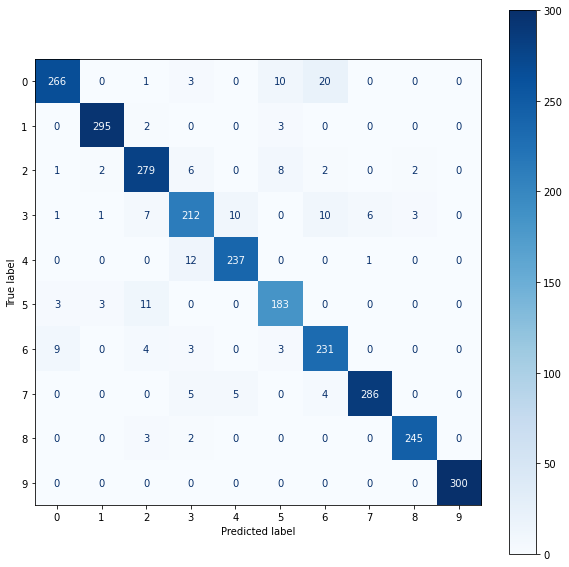

In [30]:
plot_confusion_matrix(trueLabels, predLabels)

In [31]:
def m(X):
  # Go from (batch size, height, width, channels)
  #      to (batch size, channels, height, width)
  X = np.moveaxis(X, (0, 1, 2, 3), (0, 2, 3, 1))

  # Numpy to pytorch tensor
  # image = val_transform(X)
  image = torch.from_numpy(X)  #.ToTensor()

  # Prepare input, model for evaluation
  image = image.to("cpu", dtype=torch.double)
  
  # Evaluate model
  res = model(image)
  return res.detach().numpy()

In [32]:
# Get batch of images, labels
batch = next(iter(val_loader))
X = batch[0]
y = batch[1]

# Convert from tensor (from pytorch) to generic numpy (for shap)
Xshap = X.numpy()
# Go from (batch size, channels, height, width)
#      to (batch size, height, width, channels)
Xshap = np.moveaxis(Xshap, (0, 1, 2, 3), (0, 3, 1, 2))

classes = trainData.classes

In [33]:
def explain_singleband(masker):
  explainer = shap.Explainer(m, masker, output_names=classes)

  # Explain batch (calculate shap values)
  shap_values = explainer(Xshap[0:2], max_evals=500, batch_size=batchSize, outputs=shap.Explanation.argsort.flip[:4])

  toplot = range(0, 2)
  Xplot = np.array([(Xshap[t] - np.min(Xshap[t]))/np.ptp(Xshap[t]) for t in toplot])
  shap.image_plot(shap_values, pixel_values=Xplot[:,:,:,(3, 2, 1)])

In [34]:
# define maskers
# See masker documentation for details: 
#    https://shap.readthedocs.io/en/latest/generated/shap.maskers.Image.html#shap.maskers.Image
masker_inpaint_telea = shap.maskers.Image("inpaint_telea", Xshap[0].shape)
masker_inpaint_ns    = shap.maskers.Image("inpaint_ns", Xshap[0].shape)
masker_blur_3x3      = shap.maskers.Image("blur(3, 3)", Xshap[0].shape)
masker_blur_10x10    = shap.maskers.Image("blur(10, 10)", Xshap[0].shape)
masker_blur_100x100  = shap.maskers.Image("blur(100, 100)", Xshap[0].shape)
masker_uniform_black = shap.maskers.Image(np.zeros_like(Xshap[0]), Xshap[0].shape)
masker_uniform_gray  = shap.maskers.Image(np.zeros_like(Xshap[0]) + 128, Xshap[0].shape)
masker_uniform_white = shap.maskers.Image(np.zeros_like(Xshap[0]) + 255, Xshap[0].shape)

In [ ]:
# Masker: inpaint telea
#explain_singleband(masker_inpaint_telea)

# Does not support 12-bit images: 
# "(-210:Unsupported format or combination of formats) 
# 8-bit, 16-bit unsigned or 32-bit float 1-channel and 
# 8-bit 3-channel input/output images are supported in function 'icvInpaint'"

In [ ]:
# Masker: inpaint NS
# explain_singleband(masker_inpaint_ns)

# Does not support 12-bit images: 
# "(-210:Unsupported format or combination of formats) 
# 8-bit, 16-bit unsigned or 32-bit float 1-channel and 
# 8-bit 3-channel input/output images are supported in function 'icvInpaint'"

Partition explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

Partition explainer: 3it [00:27,  9.14s/it]


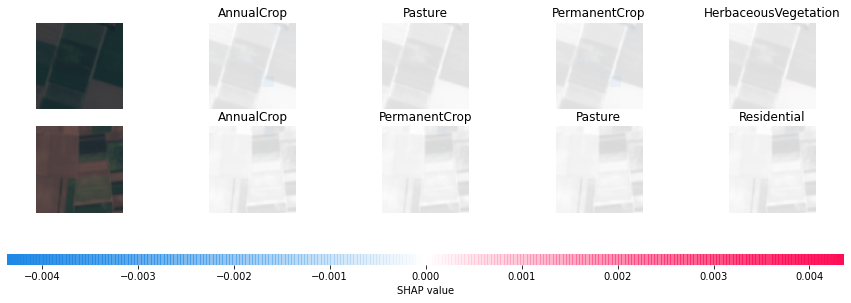

In [35]:
# Masker 3x3 blur kernel
explain_singleband(masker_blur_3x3)

Partition explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

Partition explainer: 3it [00:25,  8.61s/it]


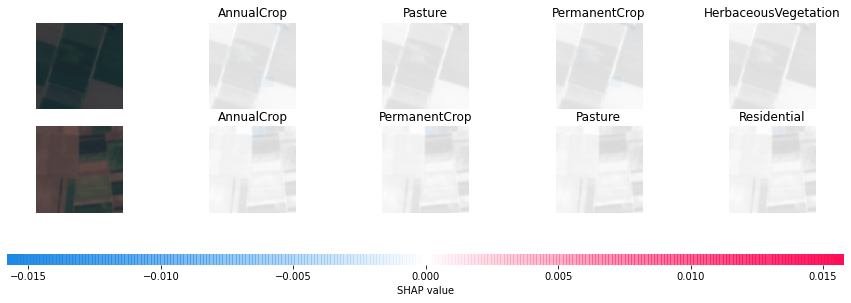

In [36]:
# Masker 10x10 blur kernel
explain_singleband(masker_blur_10x10)

Partition explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

Partition explainer: 3it [00:25,  8.38s/it]


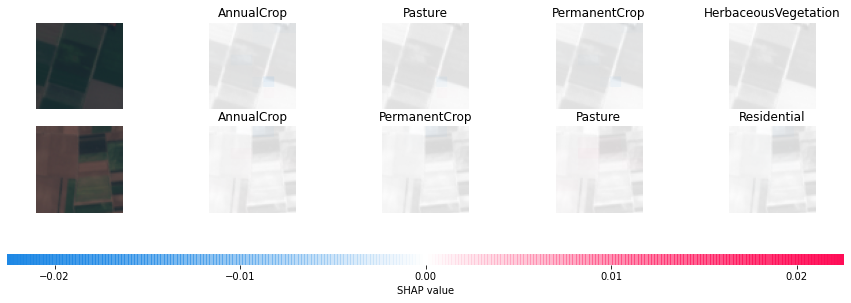

In [37]:
# Masker: 100x100 blur kernel
explain_singleband(masker_blur_100x100)

Partition explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

Partition explainer: 3it [00:25,  8.40s/it]


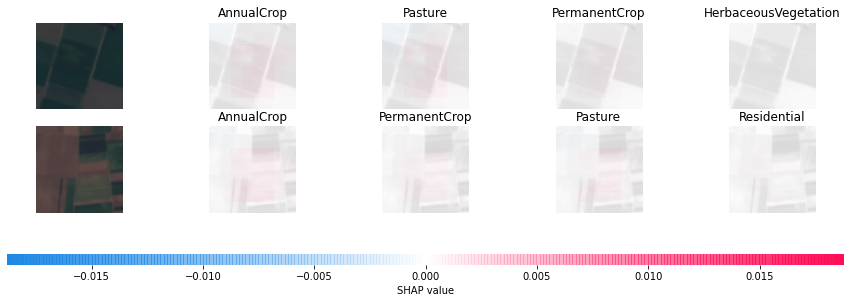

In [38]:
# Masker: black image
explain_singleband(masker_uniform_black)

Partition explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

Partition explainer: 3it [00:25,  8.48s/it]


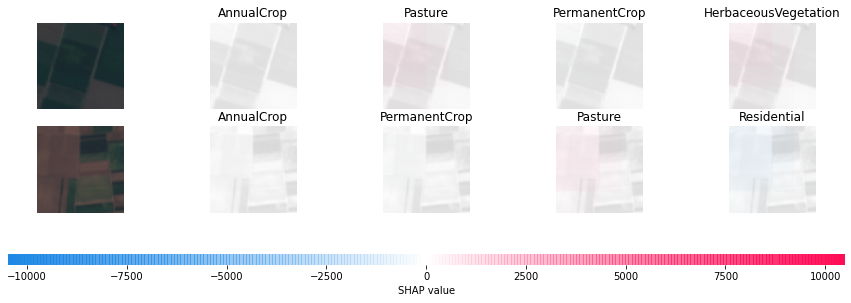

In [39]:
# Masker: gray image
explain_singleband(masker_uniform_gray)

Partition explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

Partition explainer: 3it [00:24,  8.20s/it]


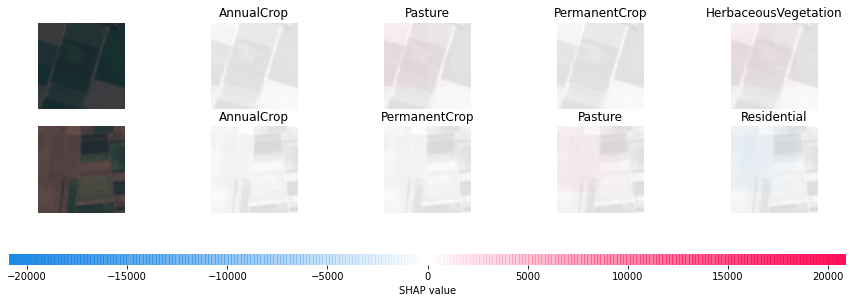

In [40]:
# Masker: white image
explain_singleband(masker_uniform_white)

In [41]:
def explain_multiband(masker):
  explainer = shap.Explainer(m, masker, output_names=classes)

  # Explain batch (calculate shap values)
  shap_values = explainer(Xshap[0:2], max_evals=5000, batch_size=batchSize, outputs=shap.Explanation.argsort.flip[:4])

  toplot = range(0,2)
  Xplot = np.array([(Xshap[t] - np.min(Xshap[t]))/np.ptp(Xshap[t]) for t in toplot])
  shap.image_plot(shap_values, pixel_values=Xplot[:,:,:,(4, 2, 1)],  plotchannels=list(range(13)), hspace=0.3)

  return shap_values

In [42]:
masker_inpaint_telea = shap.maskers.Image("inpaint_telea", Xshap[0].shape, partition_scheme=1)
masker_inpaint_ns    = shap.maskers.Image("inpaint_ns", Xshap[0].shape, partition_scheme=1)
masker_blur_3x3      = shap.maskers.Image("blur(3, 3)", Xshap[0].shape, partition_scheme=1)
masker_blur_10x10    = shap.maskers.Image("blur(10, 10)", Xshap[0].shape, partition_scheme=1)
masker_blur_100x100  = shap.maskers.Image("blur(100, 100)", Xshap[0].shape, partition_scheme=1)
masker_uniform_black = shap.maskers.Image(np.zeros_like(Xshap[0]), Xshap[0].shape, partition_scheme=1)
masker_uniform_gray  = shap.maskers.Image(np.zeros_like(Xshap[0]) + 128, Xshap[0].shape, partition_scheme=1)
masker_uniform_white = shap.maskers.Image(np.zeros_like(Xshap[0]) + 255, Xshap[0].shape, partition_scheme=1)

In [43]:
def save_shap(shap_values, filename, Class=0):
  # Save selected SHAP values
  # image0 = shap_values[0, :, :, :, Class].values
  # image1 = shap_values[1, :, :, :, Class].values
  # np.savez_compressed(filename, array_0=image0, array_1=image1)

  # Save all SHAP values
  with open(filename, 'wb') as f:
        pickle.dump(shap_values, f)

In [ ]:
# Masker: inpaint telea
# shap_values = explain_multiband(masker_inpaint_telea)
# save_shap(shap_values, "shap_eurosat_13band_multiband_inpaint-telea.npz")

# Does not support 12-bit images: 
# "(-210:Unsupported format or combination of formats) 
# 8-bit, 16-bit unsigned or 32-bit float 1-channel and 
# 8-bit 3-channel input/output images are supported in function 'icvInpaint'"

In [ ]:
# Masker: inpaint NS
# shap_values = explain_multiband(masker_inpaint_ns)
# save_shap(shap_values, "shap_eurosat_13band_multiband_inpaint-ns.npz")

# Does not support 12-bit images: 
# "(-210:Unsupported format or combination of formats) 
# 8-bit, 16-bit unsigned or 32-bit float 1-channel and 
# 8-bit 3-channel input/output images are supported in function 'icvInpaint'"

Partition explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

Partition explainer: 3it [03:23, 67.96s/it]


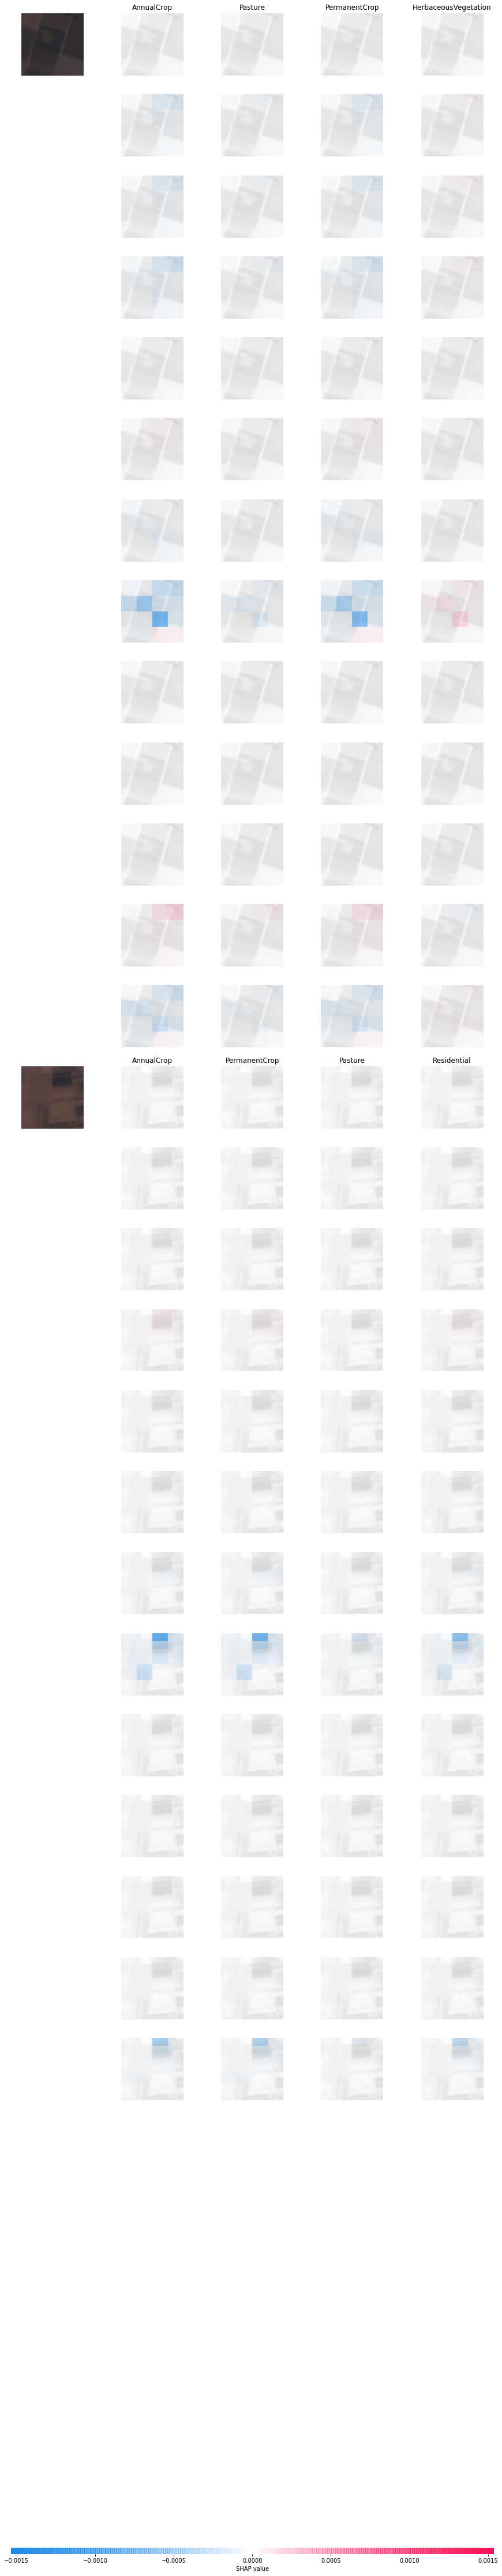

In [45]:
# Masker 3x3 blur kernel
shap_values = explain_multiband(masker_blur_3x3)
save_shap(shap_values, "shap_eurosat_13band_multiband_blur-3x3.pickle")

Partition explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

Partition explainer: 3it [03:20, 66.80s/it]


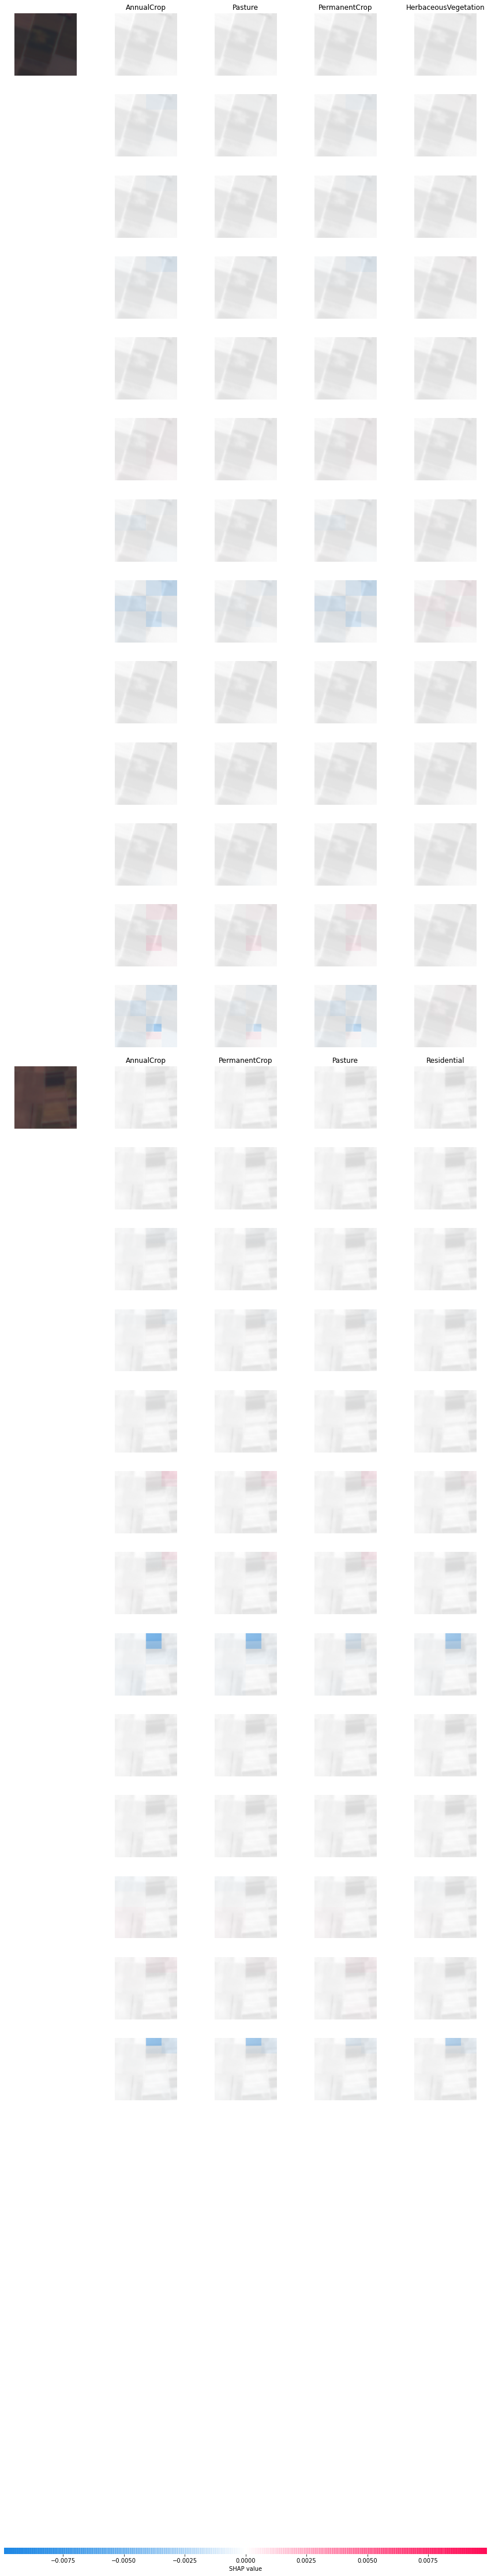

In [46]:
# Masker 10x10 blur kernel
shap_values = explain_multiband(masker_blur_10x10)
save_shap(shap_values, "shap_eurosat_13band_multiband_blur-10x10.pickle")

Partition explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

Partition explainer: 3it [03:22, 67.62s/it]


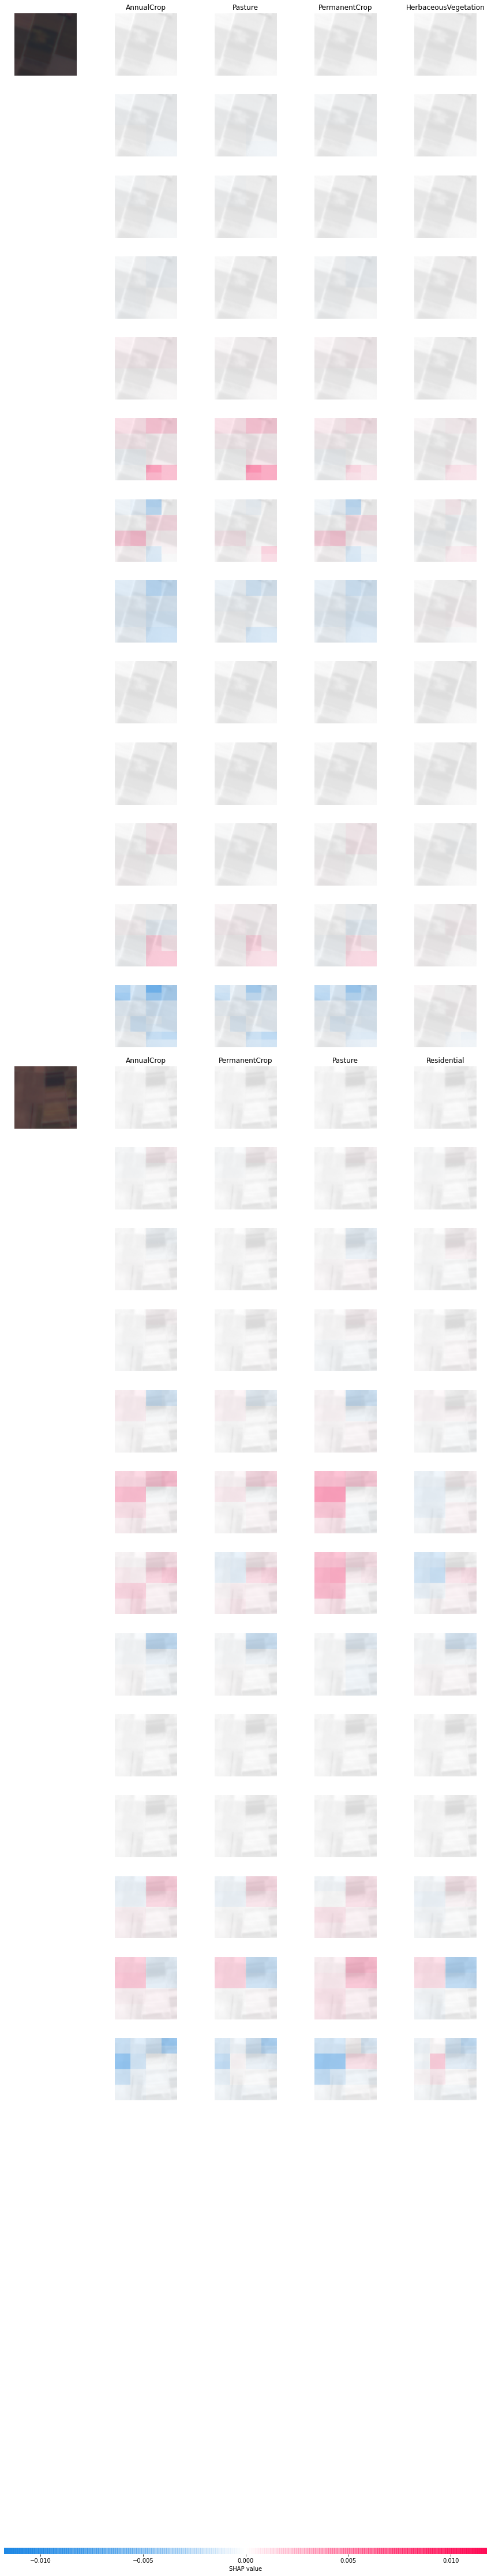

In [47]:
# Masker: 100x100 blur kernel
shap_values = explain_multiband(masker_blur_100x100)
save_shap(shap_values, "shap_eurosat_13band_multiband_blur-100x100.pickle")

Partition explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

Partition explainer: 3it [03:19, 66.47s/it]


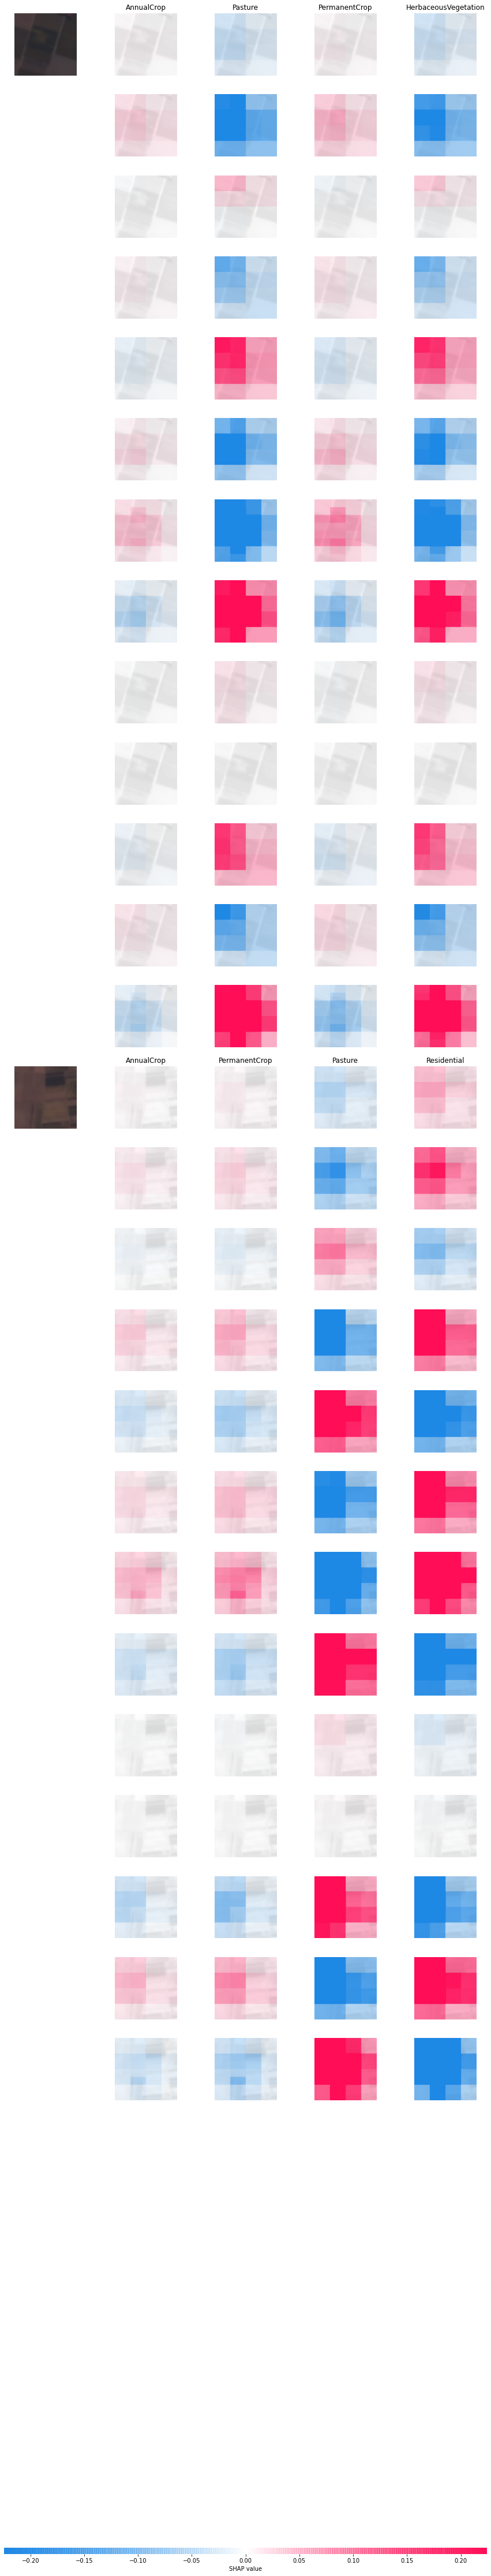

In [48]:
# Masker: black image
shap_values = explain_multiband(masker_uniform_black)
save_shap(shap_values, "shap_eurosat_13band_multiband_uniform-black.pickle")

Partition explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

Partition explainer: 3it [03:23, 67.89s/it]


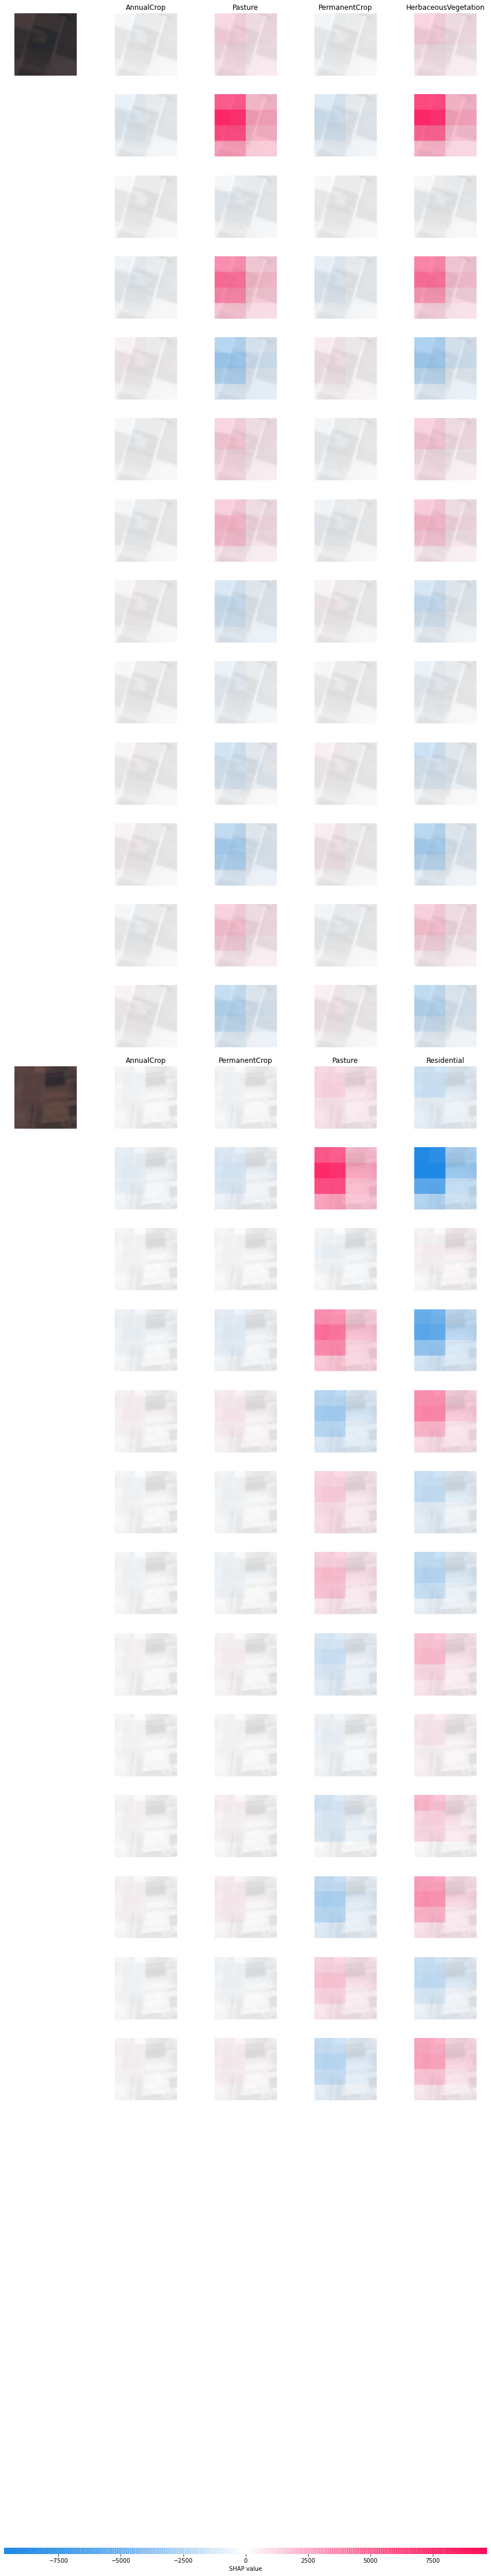

In [49]:
# Masker: gray image
shap_values = explain_multiband(masker_uniform_gray)
save_shap(shap_values, "shap_eurosat_13band_multiband_uniform-gray.pickle")

Partition explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

Partition explainer: 3it [03:20, 66.94s/it]


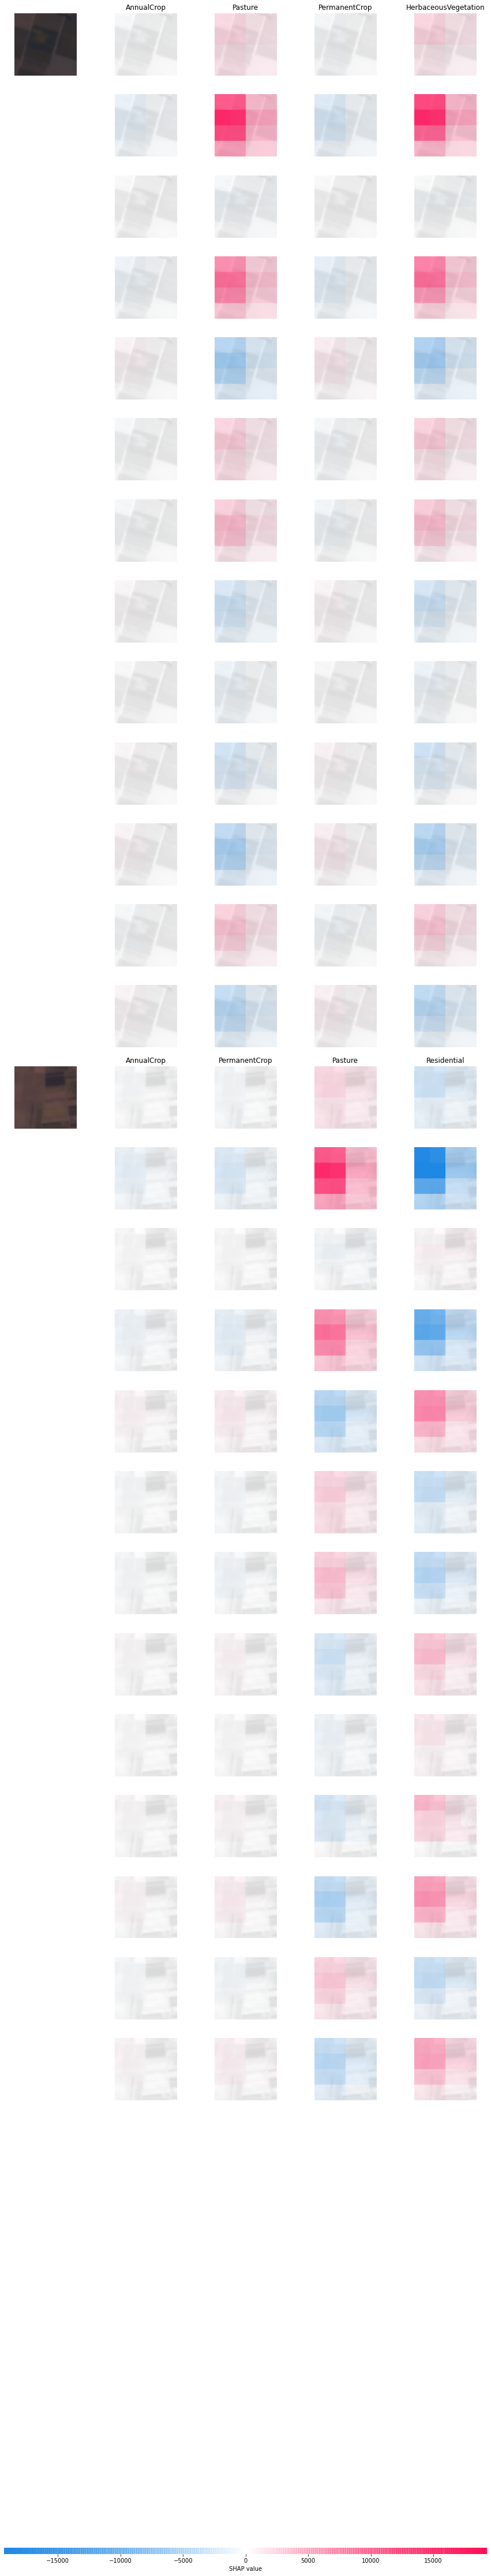

In [50]:
# Masker: white image
shap_values = explain_multiband(masker_uniform_white)
save_shap(shap_values, "shap_eurosat_13band_multiband_uniform-white.pickle")